In [2]:
import sys
# sys.path.append('/content/eth-capstone-treewater-deficit/src')
sys.path.append('/home/renku/work/eth-capstone-treewater-deficit/src')
import os
import glob 
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import collections

from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


from sklearn.preprocessing import StandardScaler
import treewater.utils as utils
# from treewater.utils import *

2026-01-27 23:10:23.254898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:

import importlib
importlib.reload(utils)

# check presence

print(hasattr(utils, "compute_recursive_predictions_fast_torch"))

True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# set global random seed
seed = 66666
torch.manual_seed(seed)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress INFO + WARNING

In [6]:
derived_path = "/home/renku/work/eth-capstone-treewater-deficit/data"
data_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/tstoy04"
model_output_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/derived/model_outputs/"

# derived_path = "/content/eth-capstone-treewater-deficit/data"
# data_dir = "/content/eth-capstone-treewater-deficit/data/tstoy04"

# model_output_dir = '/content/eth-capstone-treewater-deficit/data/derived/model_outputs/'

In [7]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [8]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [9]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [10]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [11]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [12]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

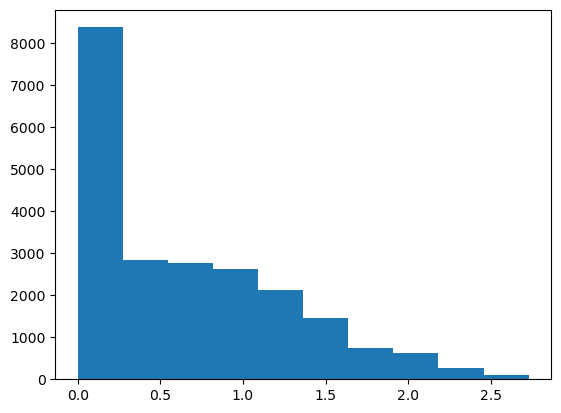

In [13]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [14]:
# Configure features

config = utils.FeatureConfig()
lag_n =7 # use 7 and smaller model size 

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = utils.create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = utils.standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = utils.get_dataset_NN_torch(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = utils.get_dataset_NN_torch(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)





In [15]:
val_X_ts_at.shape

torch.Size([3260, 7, 7])

### build transformer

In [16]:
batch_size = 256
lag_n = lag_n

### Autoregressive

In [17]:
# building datasets
batch_size = batch_size
# train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at

# ensure tensors are on CPU for DataLoader
if train_X_ts_at.device.type == "cuda":
    train_X_ts_at = train_X_ts_at.cpu(); train_day_feat_X_at = train_day_feat_X_at.cpu(); train_static_X_ts_at = train_static_X_ts_at.cpu(); train_y_at = train_y_at.cpu()
train_ds = TensorDataset(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, train_y_at)
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)

# validation dataset

if val_X_ts_at.device.type == "cuda":
    val_X_ts_at = val_X_ts_at.cpu(); val_day_feat_X_at = val_day_feat_X_at.cpu(); val_static_X_ts_at = val_static_X_ts_at.cpu(); val_y_at = val_y_at.cpu()

val_loader = DataLoader(TensorDataset(val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at),
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=2)


# create cross validate datasets 
# create cross validation dataframes 

train_val_datasets_at = utils.cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df, val_cv_df in train_val_datasets_at:
    X_tr, Xd_tr, Xs_tr, y_tr = utils.get_dataset_NN_torch(train_cv_df, feature_window_size=lag_n, autoregressive=True, config=config)
    if X_tr.device.type == "cuda":
        X_tr = X_tr.cpu(); Xd_tr = Xd_tr.cpu(); Xs_tr = Xs_tr.cpu(); y_tr = y_tr.cpu()
    tr_loader = DataLoader(TensorDataset(X_tr, Xd_tr, Xs_tr, y_tr),
                           batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())

    X_va, Xd_va, Xs_va, y_va = utils.get_dataset_NN_torch(val_cv_df, feature_window_size=lag_n, autoregressive=True, config=config)
    if X_va.device.type == "cuda":
        X_va = X_va.cpu(); Xd_va = Xd_va.cpu(); Xs_va = Xs_va.cpu(); y_va = y_va.cpu()
    va_loader = DataLoader(TensorDataset(X_va, Xd_va, Xs_va, y_va),
                           batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    cv_train_val_ds_at.append((tr_loader, va_loader))


In [18]:
y_tr.shape

torch.Size([12120])

### Build transformer architecture

In [19]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 64):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class EncoderOnlyForecast(nn.Module):
    """
    Uses TransformerEncoderLayer + TransformerEncoder as the core architecture.
    Inputs:
      past_dynamic: (B, T, n_dyn)
      current_day_exog: (B, n_day)
      static: (B, n_static)
    Output:
      next-day twd: (B,)
    """
    def __init__(
        self,
        n_dyn: int,
        n_day: int,
        n_static: int,
        T: int = 13,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 32,
        dropout: float = 0.1,
        out_nonneg: bool = False,
    ):
        super().__init__()
        self.T = T
        self.out_nonneg = out_nonneg

        # project dynamic features -> d_model
        self.in_proj = nn.Linear(n_dyn, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max(T, 64))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu",
            batch_first=True,  # IMPORTANT: we use (B, T, C)
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # combine with day exog + static
        self.day_mlp = nn.Sequential(
            nn.Linear(n_day, 8),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, 8),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(d_model + 8 + 8, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
        )

    def forward(self, past_dynamic, current_day_exog, static):
        # past_dynamic: (B, T, n_dyn)
        x = self.in_proj(past_dynamic)   # (B, T, d_model)
        x = self.pos(x)
        x = self.encoder(x)              # (B, T, d_model)

        # pool: last token (works well for fixed window)
        x_seq = x[:, -1, :]              # (B, d_model)

        x_day = self.day_mlp(current_day_exog)
        x_stat = self.static_mlp(static)

        z = torch.cat([x_seq, x_day, x_stat], dim=-1)
        y = self.head(z).squeeze(-1)

        if self.out_nonneg:
            y = F.linear(y) # using linear to allow negative outputs for log2 twd

        return y


### set up cross validation

In [20]:
model_factory = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=32,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# build a training loop

loss_fn = torch.nn.HuberLoss()
optimizer = torch.optim.Adam(model_factory().parameters(), lr=1e-3/2)

rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = utils.cross_validate_transformer(
    model_factory=model_factory,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


model_factory_2 = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=64,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)


rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2 = utils.cross_validate_transformer(
    model_factory=model_factory_2,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting fold 1/4
Epoch 1/50


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.1614, Train RMSE: 0.5857
  Validation Loss: 0.2134, Validation RMSE: 0.6824
Epoch 2/50
  Train Loss: 0.1013, Train RMSE: 0.4587
  Validation Loss: 0.2035, Validation RMSE: 0.6592
Epoch 3/50
  Train Loss: 0.0700, Train RMSE: 0.3762
  Validation Loss: 0.1426, Validation RMSE: 0.5426
Epoch 4/50
  Train Loss: 0.0496, Train RMSE: 0.3173
  Validation Loss: 0.0891, Validation RMSE: 0.4249
Epoch 5/50
  Train Loss: 0.0401, Train RMSE: 0.2844
  Validation Loss: 0.0732, Validation RMSE: 0.3843
Epoch 6/50
  Train Loss: 0.0339, Train RMSE: 0.2619
  Validation Loss: 0.0652, Validation RMSE: 0.3624
Epoch 7/50
  Train Loss: 0.0314, Train RMSE: 0.2509
  Validation Loss: 0.0524, Validation RMSE: 0.3247
Epoch 8/50
  Train Loss: 0.0284, Train RMSE: 0.2393
  Validation Loss: 0.0476, Validation RMSE: 0.3094
Epoch 9/50
  Train Loss: 0.0273, Train RMSE: 0.2332
  Validation Loss: 0.0445, Validation RMSE: 0.2991
Epoch 10/50
  Train Loss: 0.0262, Train RMSE: 0.2294
  Validation Loss: 0.0407, Vali

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.1525, Train RMSE: 0.5696
  Validation Loss: 0.0851, Validation RMSE: 0.4147
Epoch 2/50
  Train Loss: 0.0629, Train RMSE: 0.3562
  Validation Loss: 0.0527, Validation RMSE: 0.3264
Epoch 3/50
  Train Loss: 0.0421, Train RMSE: 0.2902
  Validation Loss: 0.0420, Validation RMSE: 0.2912
Epoch 4/50
  Train Loss: 0.0336, Train RMSE: 0.2591
  Validation Loss: 0.0362, Validation RMSE: 0.2709
Epoch 5/50
  Train Loss: 0.0287, Train RMSE: 0.2393
  Validation Loss: 0.0326, Validation RMSE: 0.2574
Epoch 6/50
  Train Loss: 0.0268, Train RMSE: 0.2316
  Validation Loss: 0.0337, Validation RMSE: 0.2617
Epoch 7/50
  Train Loss: 0.0257, Train RMSE: 0.2270
  Validation Loss: 0.0308, Validation RMSE: 0.2505
Epoch 8/50
  Train Loss: 0.0239, Train RMSE: 0.2187
  Validation Loss: 0.0298, Validation RMSE: 0.2463
Epoch 9/50
  Train Loss: 0.0231, Train RMSE: 0.2155
  Validation Loss: 0.0279, Validation RMSE: 0.2388
Epoch 10/50
  Train Loss: 0.0221, Train RMSE: 0.2105
  Validation Loss: 0.0278, Vali

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.1072, Train RMSE: 0.4728
  Validation Loss: 0.0387, Validation RMSE: 0.2780
Epoch 2/50
  Train Loss: 0.0424, Train RMSE: 0.2918
  Validation Loss: 0.0247, Validation RMSE: 0.2224
Epoch 3/50
  Train Loss: 0.0338, Train RMSE: 0.2613
  Validation Loss: 0.0195, Validation RMSE: 0.1981
Epoch 4/50
  Train Loss: 0.0296, Train RMSE: 0.2443
  Validation Loss: 0.0169, Validation RMSE: 0.1841
Epoch 5/50
  Train Loss: 0.0265, Train RMSE: 0.2314
  Validation Loss: 0.0152, Validation RMSE: 0.1748
Epoch 6/50
  Train Loss: 0.0248, Train RMSE: 0.2241
  Validation Loss: 0.0143, Validation RMSE: 0.1698
Epoch 7/50
  Train Loss: 0.0237, Train RMSE: 0.2179
  Validation Loss: 0.0137, Validation RMSE: 0.1663
Epoch 8/50
  Train Loss: 0.0222, Train RMSE: 0.2121
  Validation Loss: 0.0134, Validation RMSE: 0.1640
Epoch 9/50
  Train Loss: 0.0211, Train RMSE: 0.2074
  Validation Loss: 0.0133, Validation RMSE: 0.1638
Epoch 10/50
  Train Loss: 0.0210, Train RMSE: 0.2065
  Validation Loss: 0.0127, Vali

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0754, Train RMSE: 0.3919
  Validation Loss: 0.0315, Validation RMSE: 0.2511
Epoch 2/50
  Train Loss: 0.0334, Train RMSE: 0.2596
  Validation Loss: 0.0255, Validation RMSE: 0.2261
Epoch 3/50
  Train Loss: 0.0269, Train RMSE: 0.2323
  Validation Loss: 0.0244, Validation RMSE: 0.2215
Epoch 4/50
  Train Loss: 0.0243, Train RMSE: 0.2214
  Validation Loss: 0.0238, Validation RMSE: 0.2188
Epoch 5/50
  Train Loss: 0.0225, Train RMSE: 0.2128
  Validation Loss: 0.0205, Validation RMSE: 0.2031
Epoch 6/50
  Train Loss: 0.0215, Train RMSE: 0.2083
  Validation Loss: 0.0205, Validation RMSE: 0.2027
Epoch 7/50
  Train Loss: 0.0200, Train RMSE: 0.2013
  Validation Loss: 0.0189, Validation RMSE: 0.1947
Epoch 8/50
  Train Loss: 0.0196, Train RMSE: 0.1990
  Validation Loss: 0.0182, Validation RMSE: 0.1916
Epoch 9/50
  Train Loss: 0.0188, Train RMSE: 0.1952
  Validation Loss: 0.0190, Validation RMSE: 0.1952
Epoch 10/50
  Train Loss: 0.0187, Train RMSE: 0.1950
  Validation Loss: 0.0179, Vali

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.1051, Train RMSE: 0.4642
  Validation Loss: 0.2366, Validation RMSE: 0.7134
Epoch 3/50
  Train Loss: 0.0721, Train RMSE: 0.3826
  Validation Loss: 0.1639, Validation RMSE: 0.5833
Epoch 4/50
  Train Loss: 0.0481, Train RMSE: 0.3122
  Validation Loss: 0.0729, Validation RMSE: 0.3838
Epoch 5/50
  Train Loss: 0.0382, Train RMSE: 0.2778
  Validation Loss: 0.0673, Validation RMSE: 0.3684
Epoch 6/50
  Train Loss: 0.0324, Train RMSE: 0.2566
  Validation Loss: 0.0650, Validation RMSE: 0.3623
Epoch 7/50
  Train Loss: 0.0295, Train RMSE: 0.2422
  Validation Loss: 0.0653, Validation RMSE: 0.3631
Epoch 8/50
  Train Loss: 0.0256, Train RMSE: 0.2271
  Validation Loss: 0.0547, Validation RMSE: 0.3322
Epoch 9/50
  Train Loss: 0.0254, Train RMSE: 0.2258
  Validation Loss: 0.0498, Validation RMSE: 0.3166
Epoch 10/50
  Train Loss: 0.0239, Train RMSE: 0.2183
  Validation Loss: 0.0492, Validation RMSE: 0.3149
Epoch 11/50
  Train Loss: 0.0236, Train RMSE: 0.2175
  Validation Loss: 0.0481, Val

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.1138, Train RMSE: 0.4868
  Validation Loss: 0.0638, Validation RMSE: 0.3582
Epoch 2/50
  Train Loss: 0.0423, Train RMSE: 0.2918
  Validation Loss: 0.0447, Validation RMSE: 0.3003
Epoch 3/50
  Train Loss: 0.0299, Train RMSE: 0.2449
  Validation Loss: 0.0374, Validation RMSE: 0.2750
Epoch 4/50
  Train Loss: 0.0253, Train RMSE: 0.2246
  Validation Loss: 0.0317, Validation RMSE: 0.2534
Epoch 5/50
  Train Loss: 0.0229, Train RMSE: 0.2146
  Validation Loss: 0.0297, Validation RMSE: 0.2457
Epoch 6/50
  Train Loss: 0.0214, Train RMSE: 0.2063
  Validation Loss: 0.0290, Validation RMSE: 0.2429
Epoch 7/50
  Train Loss: 0.0203, Train RMSE: 0.2013
  Validation Loss: 0.0277, Validation RMSE: 0.2373
Epoch 8/50
  Train Loss: 0.0189, Train RMSE: 0.1951
  Validation Loss: 0.0267, Validation RMSE: 0.2331
Epoch 9/50
  Train Loss: 0.0183, Train RMSE: 0.1913
  Validation Loss: 0.0263, Validation RMSE: 0.2317
Epoch 10/50
  Train Loss: 0.0183, Train RMSE: 0.1913
  Validation Loss: 0.0272, Vali

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0889, Train RMSE: 0.4294
  Validation Loss: 0.0274, Validation RMSE: 0.2349
Epoch 2/50
  Train Loss: 0.0353, Train RMSE: 0.2669
  Validation Loss: 0.0196, Validation RMSE: 0.1986
Epoch 3/50
  Train Loss: 0.0284, Train RMSE: 0.2391
  Validation Loss: 0.0172, Validation RMSE: 0.1859
Epoch 4/50
  Train Loss: 0.0258, Train RMSE: 0.2282
  Validation Loss: 0.0160, Validation RMSE: 0.1797
Epoch 5/50
  Train Loss: 0.0238, Train RMSE: 0.2202
  Validation Loss: 0.0149, Validation RMSE: 0.1733
Epoch 6/50
  Train Loss: 0.0220, Train RMSE: 0.2109
  Validation Loss: 0.0153, Validation RMSE: 0.1754
Epoch 7/50
  Train Loss: 0.0212, Train RMSE: 0.2073
  Validation Loss: 0.0141, Validation RMSE: 0.1681
Epoch 8/50
  Train Loss: 0.0199, Train RMSE: 0.2007
  Validation Loss: 0.0131, Validation RMSE: 0.1621
Epoch 9/50
  Train Loss: 0.0195, Train RMSE: 0.1988
  Validation Loss: 0.0132, Validation RMSE: 0.1630
Epoch 10/50
  Train Loss: 0.0193, Train RMSE: 0.1975
  Validation Loss: 0.0126, Vali

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0800, Train RMSE: 0.4055
  Validation Loss: 0.0297, Validation RMSE: 0.2438
Epoch 2/50
  Train Loss: 0.0303, Train RMSE: 0.2467
  Validation Loss: 0.0227, Validation RMSE: 0.2135
Epoch 3/50
  Train Loss: 0.0253, Train RMSE: 0.2253
  Validation Loss: 0.0214, Validation RMSE: 0.2078
Epoch 4/50
  Train Loss: 0.0231, Train RMSE: 0.2156
  Validation Loss: 0.0195, Validation RMSE: 0.1980
Epoch 5/50
  Train Loss: 0.0212, Train RMSE: 0.2063
  Validation Loss: 0.0185, Validation RMSE: 0.1933
Epoch 6/50
  Train Loss: 0.0201, Train RMSE: 0.2023
  Validation Loss: 0.0194, Validation RMSE: 0.1975
Epoch 7/50
  Train Loss: 0.0190, Train RMSE: 0.1958
  Validation Loss: 0.0175, Validation RMSE: 0.1881
Epoch 8/50
  Train Loss: 0.0185, Train RMSE: 0.1933
  Validation Loss: 0.0175, Validation RMSE: 0.1880
Epoch 9/50
  Train Loss: 0.0182, Train RMSE: 0.1910
  Validation Loss: 0.0167, Validation RMSE: 0.1840
Epoch 10/50
  Train Loss: 0.0184, Train RMSE: 0.1929
  Validation Loss: 0.0167, Vali

[Text(1, 0, 'hidden size =32'), Text(2, 0, 'hidden size =64')]

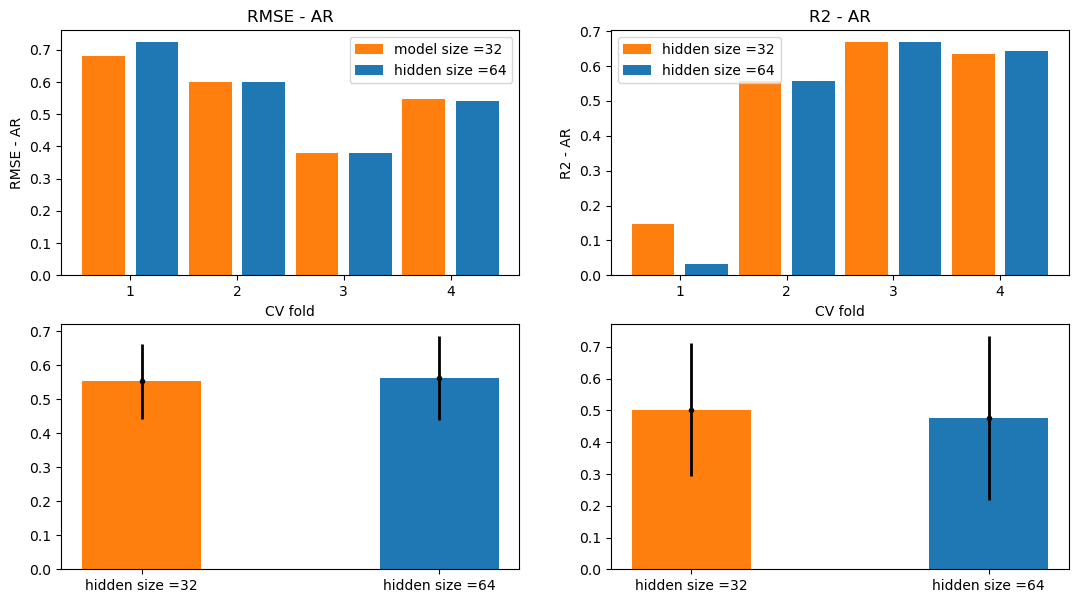

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['model size =32', 'hidden size =64'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =32', 'hidden size =64'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =32', 'hidden size =64'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =32', 'hidden size =64'])

In [22]:
# visualize CV results
for fold in range(len(rmses_cv_at)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at[fold]:.4f}, Recursive R2={r2s_cv_at[fold]:.4f}, 1-day R2={r2s_cv_1d_at[fold]:.4f}')

Fold 1: Recursive RMSE=0.6807, 1-day RMSE=0.3259, Recursive R2=0.1463, 1-day R2=0.8006
Fold 2: Recursive RMSE=0.6011, 1-day RMSE=0.3264, Recursive R2=0.5561, 1-day R2=0.8655
Fold 3: Recursive RMSE=0.3795, 1-day RMSE=0.1681, Recursive R2=0.6689, 1-day R2=0.9430
Fold 4: Recursive RMSE=0.5479, 1-day RMSE=0.2650, Recursive R2=0.6350, 1-day R2=0.9156


maybe test different model size?

In [23]:
model_ar = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=32, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device)

optimizer = torch.optim.Adam(model_ar.parameters(), lr=1e-3/2)



# writer = SummaryWriter(os.path.join(model_output_dir, f'transformer_ar{timestamp}'))
epoch_number = 0

history = {"train_loss": [], "train_rmse": [], "val_loss": [], "val_rmse": [],
           "p_tf": []}
best_vloss = float("inf")

EPOCHS = 80

best_vloss = 1_000_000.


for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_ar.train(True)
    avg_loss, train_rmse = utils.train_one_epoch(model_ar, epoch_number, train_loader, loss_fn, optimizer,
                                           device=device, log_every=100)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_ar.eval()
    val_sse = 0.0
    val_n = 0   
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
            voutputs = model_ar(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            running_vloss += vloss
            val_sse += F.mse_loss(voutputs, vlabels.to(device), reduction='sum').item()
            val_n += vlabels.numel()



    avg_vloss = running_vloss / (i + 1)
    avg_vloss_f = avg_vloss.item() if hasattr(avg_vloss, "item") else float(avg_vloss)

    val_rmse = math.sqrt(val_sse / val_n) if val_n > 0 else float("nan")
    print(f'Train loss:{avg_loss:.4f}, Train RMSE:{train_rmse:.4f}, Val loss:{avg_vloss:.4f}, Val RMSE:{val_rmse:.4f}')
    # Log the running loss averaged per batch
    # for both training and validation

    history["train_loss"].append(float(avg_loss))
    history["val_loss"].append(avg_vloss_f)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_output_dir, f'model_{epoch_number}')
        torch.save(model_ar.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train loss:0.1352, Train RMSE:0.5370, Val loss:0.0369, Val RMSE:0.2728
EPOCH 2:
Train loss:0.0392, Train RMSE:0.2806, Val loss:0.0212, Val RMSE:0.2069
EPOCH 3:
Train loss:0.0322, Train RMSE:0.2546, Val loss:0.0173, Val RMSE:0.1872
EPOCH 4:
Train loss:0.0278, Train RMSE:0.2370, Val loss:0.0154, Val RMSE:0.1764
EPOCH 5:
Train loss:0.0252, Train RMSE:0.2258, Val loss:0.0151, Val RMSE:0.1749
EPOCH 6:
Train loss:0.0237, Train RMSE:0.2189, Val loss:0.0137, Val RMSE:0.1663
EPOCH 7:
Train loss:0.0222, Train RMSE:0.2117, Val loss:0.0132, Val RMSE:0.1633
EPOCH 8:
Train loss:0.0217, Train RMSE:0.2094, Val loss:0.0128, Val RMSE:0.1605
EPOCH 9:
Train loss:0.0202, Train RMSE:0.2025, Val loss:0.0123, Val RMSE:0.1573
EPOCH 10:
Train loss:0.0196, Train RMSE:0.1994, Val loss:0.0121, Val RMSE:0.1561
EPOCH 11:
Train loss:0.0194, Train RMSE:0.1979, Val loss:0.0118, Val RMSE:0.1543
EPOCH 12:
Train loss:0.0188, Train RMSE:0.1951, Val loss:0.0125, Val RMSE:0.1587
EPOCH 13:
Train loss:0.0187, Train RMSE:0.1939

In [24]:
# predction on validation set
model_ar.eval()
model_best = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=32, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=32, # dimension of feedforward network,
    dropout=0.1,
    out_nonneg=False
).to(device) # initiate a new model
model_best.load_state_dict(torch.load(model_path))
preds = []
actuals = []
with torch.no_grad():
    for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
        voutputs = model_best(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
        preds.append(voutputs.cpu().numpy().flatten())
        actuals.append(vlabels.cpu().numpy().flatten())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

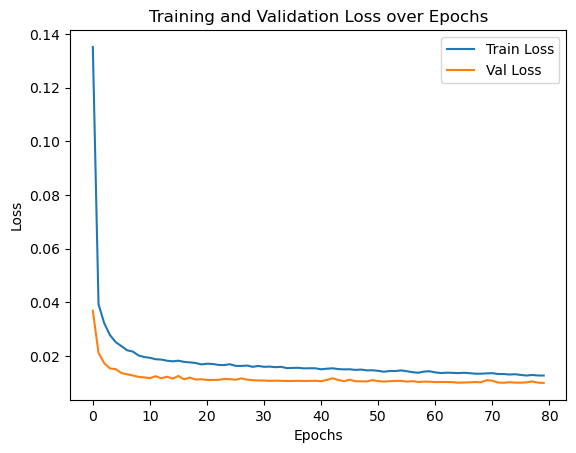

In [25]:
plt.plot(range(0, EPOCHS), history["train_loss"], label="Train Loss")
plt.plot(range(0, EPOCHS), history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

Text(4, 4.2, 'R2:0.925')

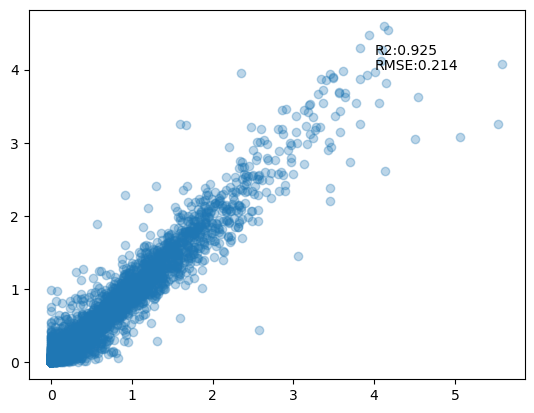

In [26]:
# next day prediction performance
rmse = root_mean_squared_error(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))
r2 = r2_score(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds))

plt.scatter(utils.clip_and_inverse_log2_transform(actuals), utils.clip_and_inverse_log2_transform(preds), alpha=0.3)
plt.text(x=4, y = 4, s = f"RMSE:{rmse:.3f}")
plt.text(x= 4, y = 4.2, s=f"R2:{r2:.3f}")



In [27]:
y_pred_val_at, y_val_at = utils.compute_recursive_predictions_fast_torch(model_best.to(device), val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=128)

Recursive prediction on validation set - RMSE: 0.4087, R2: 0.7329


Text(0.5, 1.0, '7 day prediction - transformer (rolling loss)')

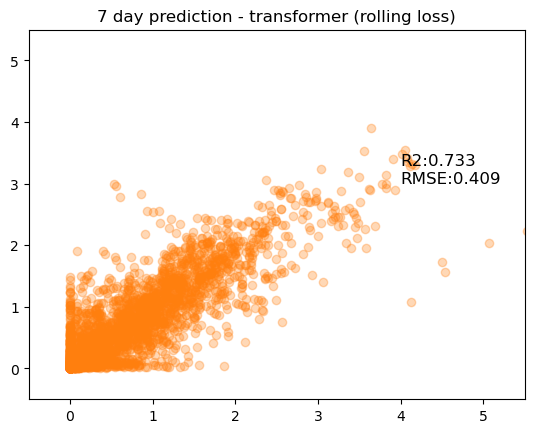

In [28]:
rmse_at= root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
r2_at = r2_score(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at))
print(f"Recursive prediction on validation set - RMSE: {rmse_at:.4f}, R2: {r2_at:.4f}")

plt.scatter(utils.clip_and_inverse_log2_transform(y_val_at), utils.clip_and_inverse_log2_transform(y_pred_val_at), alpha=0.3, color = "tab:orange")
plt.text(x=4, y = 3, s = f"RMSE:{rmse_at:.3f}", fontsize = 12)
plt.text(x= 4, y = 3.3, s=f"R2:{r2_at:.3f}", fontsize = 12)
plt.xlim(-0.5,5.5)
plt.ylim(-0.5, 5.5)
plt.title("7 day prediction - transformer (rolling loss)")



- performance appears more stable when model size is 64

In [29]:
model_size = 32

## Fine-tune model

In [30]:
# build a fresh model with identical architecture
model_FT = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_FT.load_state_dict(model_ar.state_dict())
# fine tune the model within CV

rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = utils.cross_validation_torch_FT(
    model_FT,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    batch_size = batch_size,
    loss_fn = loss_fn,
    optimizer_class = torch.optim.Adam,
    lr = 0.0005,
    n_epochs=50,
    device = device,
    if_log = True
    
)



Training fold 1/4


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/50
  Train Loss: 0.0431, Train RMSE: 0.2948
  Validation Loss: 0.0270, Validation RMSE: 0.2332
Epoch 2/50
  Train Loss: 0.0380, Train RMSE: 0.2761
  Validation Loss: 0.0217, Validation RMSE: 0.2091
Epoch 3/50
  Train Loss: 0.0370, Train RMSE: 0.2730
  Validation Loss: 0.0273, Validation RMSE: 0.2347
Epoch 4/50
  Train Loss: 0.0350, Train RMSE: 0.2651
  Validation Loss: 0.0315, Validation RMSE: 0.2520
Epoch 5/50
  Train Loss: 0.0338, Train RMSE: 0.2603
  Validation Loss: 0.0327, Validation RMSE: 0.2570
Epoch 6/50
  Train Loss: 0.0329, Train RMSE: 0.2569
  Validation Loss: 0.0407, Validation RMSE: 0.2868
Epoch 7/50
  Train Loss: 0.0322, Train RMSE: 0.2543
  Validation Loss: 0.0374, Validation RMSE: 0.2747
Epoch 8/50
  Train Loss: 0.0318, Train RMSE: 0.2524
  Validation Loss: 0.0464, Validation RMSE: 0.3060
Epoch 9/50
  Train Loss: 0.0316, Train RMSE: 0.2519
  Validation Loss: 0.0475, Validation RMSE: 0.3096
Epoch 10/50
  Train Loss: 0.0314, Train RMSE: 0.2507
  Validation Loss: 0

In [31]:
# visualize CV results
for fold in range(len(rmses_cv_at_finetune)):
    print(f'Fold {fold + 1}: Recursive RMSE={rmses_cv_at_finetune[fold]:.4f}, 1-day RMSE={rmses_cv_1d_at_finetune[fold]:.4f}, Recursive R2={r2s_cv_at_finetune[fold]:.4f}, 1-day R2={r2s_cv_1d_at_finetune[fold]:.4f}')

Fold 1: Recursive RMSE=0.8418, 1-day RMSE=0.2733, Recursive R2=-0.3058, 1-day R2=0.8597
Fold 2: Recursive RMSE=0.6013, 1-day RMSE=0.2625, Recursive R2=0.5559, 1-day R2=0.9130
Fold 3: Recursive RMSE=0.4817, 1-day RMSE=0.1616, Recursive R2=0.4665, 1-day R2=0.9474
Fold 4: Recursive RMSE=0.7556, 1-day RMSE=0.2412, Recursive R2=0.3058, 1-day R2=0.9301


In [32]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = utils.build_autoregressive_training_data_fast_torch(
    model=model_FT,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
    device = device
)

train_ds_ar = TensorDataset(X_dyn_ar.cpu(), X_day_ar.cpu(), X_static_ar.cpu() , y_ar.cpu())
train_loader_ar = DataLoader(train_ds_ar,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)



In [33]:
# train final model on the full training set with AR-corrupted data
E2 = 60


# build a fresh model with identical architecture
model_FT_all = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_FT_all.load_state_dict(model_ar.state_dict())
# fine tune the model within CV

# now fine-tune on AR-corrupted dataset
optimizer = torch.optim.Adam(model_FT_all.parameters(), lr=1e-3/2)
model_FT_all, history_FT_all = utils.train_transformer(
    model_FT_all, train_loader_ar, val_loader, loss_fn, optimizer, n_epochs=E2, device=device
    
)

Epoch 1/60


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0473, Train RMSE: 0.3090
  Validation Loss: 0.0220, Validation RMSE: 0.2108
Epoch 2/60
  Train Loss: 0.0445, Train RMSE: 0.2997
  Validation Loss: 0.0226, Validation RMSE: 0.2136
Epoch 3/60
  Train Loss: 0.0436, Train RMSE: 0.2970
  Validation Loss: 0.0197, Validation RMSE: 0.1996
Epoch 4/60
  Train Loss: 0.0427, Train RMSE: 0.2936
  Validation Loss: 0.0203, Validation RMSE: 0.2027
Epoch 5/60
  Train Loss: 0.0424, Train RMSE: 0.2927
  Validation Loss: 0.0209, Validation RMSE: 0.2054
Epoch 6/60
  Train Loss: 0.0420, Train RMSE: 0.2912
  Validation Loss: 0.0197, Validation RMSE: 0.1996
Epoch 7/60
  Train Loss: 0.0420, Train RMSE: 0.2912
  Validation Loss: 0.0256, Validation RMSE: 0.2275
Epoch 8/60
  Train Loss: 0.0412, Train RMSE: 0.2885
  Validation Loss: 0.0223, Validation RMSE: 0.2123
Epoch 9/60
  Train Loss: 0.0414, Train RMSE: 0.2893
  Validation Loss: 0.0198, Validation RMSE: 0.1998
Epoch 10/60
  Train Loss: 0.0407, Train RMSE: 0.2866
  Validation Loss: 0.0216, Vali

In [34]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = utils.compute_recursive_predictions_fast_torch(model_FT_all, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [35]:
r2_FT = r2_score(utils.clip_and_inverse_log2_transform(y_val_at_FT), utils.clip_and_inverse_log2_transform(y_pred_val_at_FT))
rmse_FT = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at_FT), utils.clip_and_inverse_log2_transform(y_pred_val_at_FT))

print(f"r2: {r2_FT}\n rmse: {rmse_FT}")

r2: 0.08412264193467733
 rmse: 0.7568128091342806


### scheduled sampling - train model

cross validation - implement cross validation

In [36]:
# build a fresh model with identical architecture
n_epochs = 50
model_at_ar_cv = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.load_state_dict(model_ar.state_dict())

rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = utils.cross_validation_torch_scheduled(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    n_epochs=n_epochs,
    batch_size = batch_size,
    loss_fn = loss_fn,
    optimizer_class = torch.optim.Adam,
    lr = 0.0005,
    p_min = 0.1,
    warmup_epochs=3,
    frac_decay=0.9,
    slow_decay=True,
    device = device,
    if_log = True)




Training fold 1/4
Epoch 1/50


/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  Train Loss: 0.0126, Train RMSE: 0.1589, p_tf: 1.0000
  Validation Loss: 0.0126, Validation RMSE: 0.1593
Epoch 2/50
  Train Loss: 0.0117, Train RMSE: 0.1534, p_tf: 1.0000
  Validation Loss: 0.0163, Validation RMSE: 0.1814
Epoch 3/50
  Train Loss: 0.0111, Train RMSE: 0.1494, p_tf: 1.0000
  Validation Loss: 0.0151, Validation RMSE: 0.1746
Epoch 4/50
  Train Loss: 0.0125, Train RMSE: 0.1580, p_tf: 0.8714
  Validation Loss: 0.0140, Validation RMSE: 0.1681
Epoch 5/50
  Train Loss: 0.0121, Train RMSE: 0.1556, p_tf: 0.8714
  Validation Loss: 0.0137, Validation RMSE: 0.1663
Epoch 6/50
  Train Loss: 0.0122, Train RMSE: 0.1560, p_tf: 0.8714
  Validation Loss: 0.0170, Validation RMSE: 0.1851
Epoch 7/50
  Train Loss: 0.0119, Train RMSE: 0.1546, p_tf: 0.8714
  Validation Loss: 0.0147, Validation RMSE: 0.1723
Epoch 8/50
  Train Loss: 0.0117, Train RMSE: 0.1529, p_tf: 0.8714
  Validation Loss: 0.0178, Validation RMSE: 0.1894
Epoch 9/50
  Train Loss: 0.0130, Train RMSE: 0.1611, p_tf: 0.7429
  Validat

In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 120


# init model with same architecture
model_ss = EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model= model_size,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dropout=0.1,
            out_nonneg=False
        ).to(device)
# copy weights from model_at (teacher-forced trained model)
model_ss.load_state_dict(model_ar.state_dict())

optimizer = torch.optim.Adam(model_ss.parameters(), lr=1e-3/2)

model_ss_best, history_at_ar = utils.train_transformer_scheduled(model_ss, train_df_at, val_loader, lag_n, 
                                                          config, batch_size, 
                                                            loss_fn, optimizer, n_epochs=num_epochs,
                                                            p_min = 0.1, warmup_epochs=3, frac_decay = 0.9, 
                                                            epoch_per_step = 15,
                                                            slow_decay = True,
                                                            device=device)

/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/120
  Train Loss: 0.0130, Train RMSE: 0.1623, p_tf: 1.0000
  Validation Loss: 0.0102, Validation RMSE: 0.1434
Epoch 2/120
  Train Loss: 0.0127, Train RMSE: 0.1600, p_tf: 1.0000
  Validation Loss: 0.0101, Validation RMSE: 0.1427
Epoch 3/120
  Train Loss: 0.0128, Train RMSE: 0.1610, p_tf: 1.0000
  Validation Loss: 0.0102, Validation RMSE: 0.1435
Epoch 4/120
  Train Loss: 0.0139, Train RMSE: 0.1672, p_tf: 0.8714
  Validation Loss: 0.0103, Validation RMSE: 0.1443
Epoch 5/120
  Train Loss: 0.0136, Train RMSE: 0.1661, p_tf: 0.8714
  Validation Loss: 0.0108, Validation RMSE: 0.1479
Epoch 6/120
  Train Loss: 0.0135, Train RMSE: 0.1648, p_tf: 0.8714
  Validation Loss: 0.0100, Validation RMSE: 0.1422
Epoch 7/120
  Train Loss: 0.0136, Train RMSE: 0.1656, p_tf: 0.8714
  Validation Loss: 0.0101, Validation RMSE: 0.1430
Epoch 8/120
  Train Loss: 0.0134, Train RMSE: 0.1643, p_tf: 0.8714
  Validation Loss: 0.0101, Validation RMSE: 0.1430
Epoch 9/120
  Train Loss: 0.0136, Train RMSE: 0.1662, p_

maybe adjust loss function?

In [ ]:
# save training history
train_his_path = os.path.join(derived_path,"derived", "training_history", "history_tranformer_scheduled_sampling_log.npy")
np.save(train_his_path, history_ar_at)

# save best model
model_path_best = os.path.join(model_output_dir, f'model_transformer_scheduled.pth')
torch.save(model_ss_best.state_dict(), model_path_best)



In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= utils.compute_recursive_predictions_fast_torch(model_ss_best, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(utils.clip_and_inverse_log2_transform(y_val_at_ar),utils.clip_and_inverse_log2_transform(y_pred_val_at_ar))
rmse_at_ar = root_mean_squared_error(utils.clip_and_inverse_log2_transform(y_val_at_ar), utils.clip_and_inverse_log2_transform(y_pred_val_at_ar))

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: 0.5830891335364017
 rmse: 0.5167026974092986


In [ ]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (model size = 32)'] *4 + ['teacher_forcing (model size = 64)'] *4 + ['fine_tuned (model size = 64)'] *4 + ['scheduled_sampling (model size = 64)'] *4,    
    "cv_fold"  : [i for i in range(1, len(rmses_cv_at_ar) + 1)] *4,
    # "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

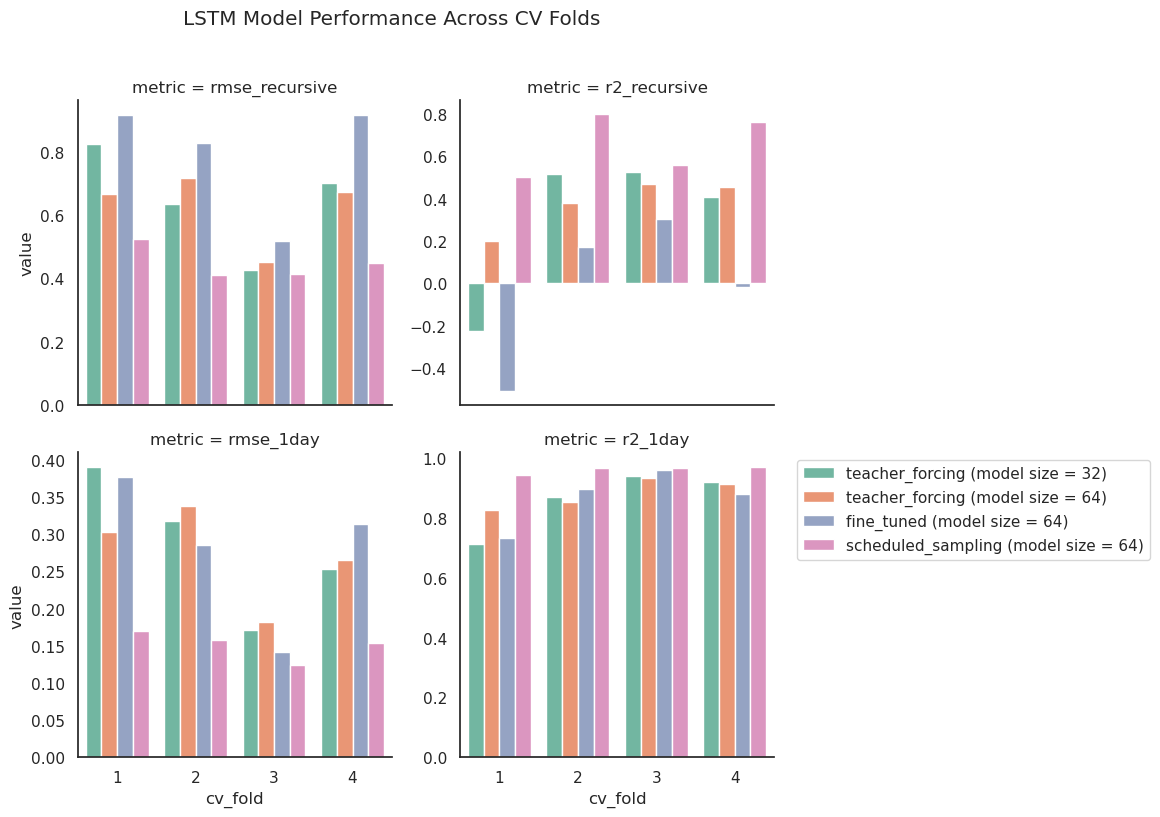

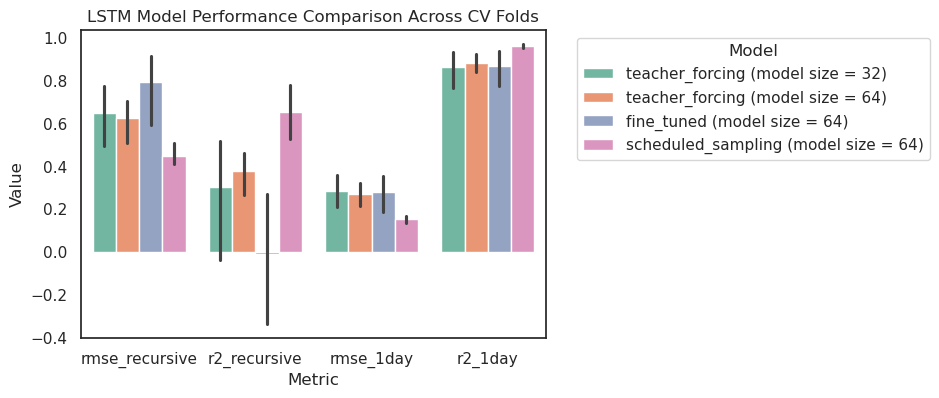

In [ ]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/tmp/ipykernel_975/3269729888.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_975/3269729888.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_975/3269729888.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_975/3269729888.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax

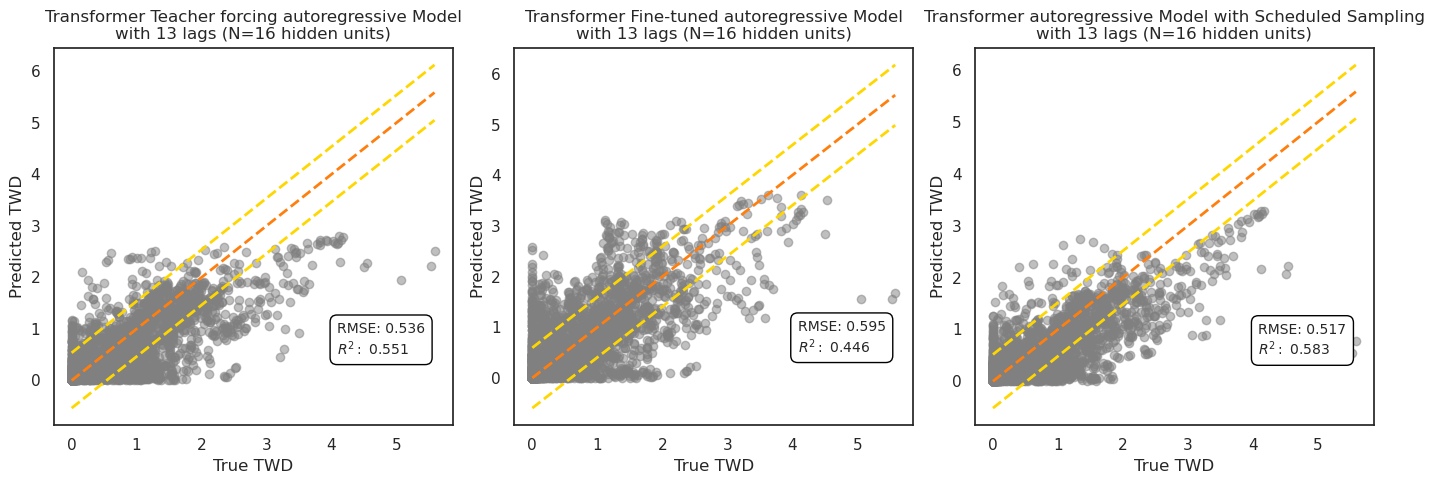

In [ ]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.numpy()
    return np.asarray(x)

model_type = "Transformer"
y_val_at = utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at).reshape(-1))
y_pred_val_at = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at).reshape(-1))
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"{model_type} Teacher forcing autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)), y = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)), color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).min(), utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"{model_type} Fine-tuned autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax2.text(utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()-1.5,utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)), y = utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)), color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).min(), utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"{model_type} autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=16 hidden units)")
ax3.text(utils.clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()-1.5,utils.clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

trained with logged values

why the performance is so bad ..
- try the same on ridge regression?
- pick the best model in different training strategy?